<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/Chap_5_(2)_NLP_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import torchtext
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import GloVe
import torch

피드포워드 신경망은 데이터의 순차적인 특성에 대한 이점을 활용하지 못한다. (참고: Chap 5-(1))

# RNN
- 한꺼번에 모든 것을 처리하지 않고 데이터를 반복하면서 처리한다
- 순차적으로 데이터를 처리할 수 있기 때문에, 서로 다른 길이의 벡터를 사용하여 서로 다른 길이의 출력을 생성한다

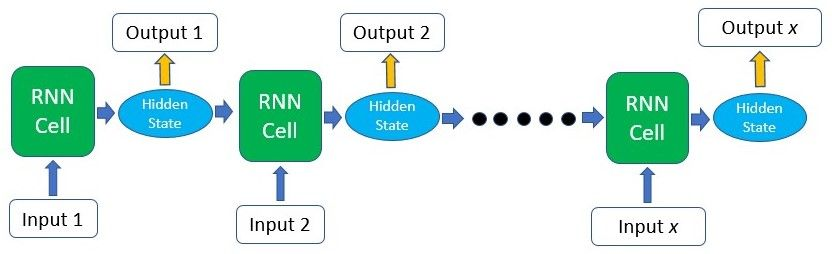


모델은 State Vector와 Output Vector을 생성한다.

코드 스니펫

```
rnn = RNN(input_size, hidden_size, output_size)
for i in range(len(toy_story_review)):
  output, hidden = rnn(toy_story_review[i], hidden)
```
hidden_state를 전달하며 나아간다.



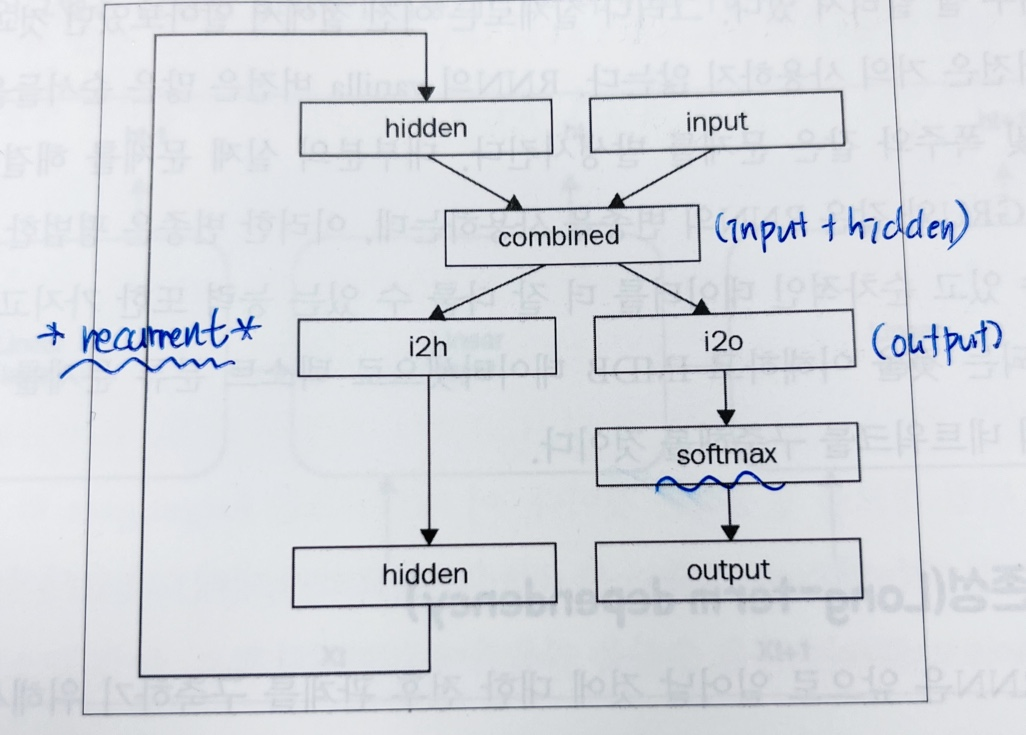

In [3]:
#RNN vanilla
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):#두 개의 선형 레이어 초기화
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)#hidden state
    self.i2o = nn.Linear(input_size+hidden_size, output_size)#output vector
    self.softmax = nn.LogSoftmax(dim = 1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)#output만 softmax를 통해 계산
    return output, hidden
  
  def initHidden(self):#hidden state 초기화
    return Variable(torch.zeros(1, self.hidden_size))#사태가 없는 hidden vector 생성

torch.cat

In [4]:
a = torch.tensor([[1,2,3],[4,5,6]])
print(a)
b = torch.tensor([[11,22,33],[44,55,66]])
print(b)
print(torch.cat((a,b),1))#가로로 붙이기

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[11, 22, 33],
        [44, 55, 66]])
tensor([[ 1,  2,  3, 11, 22, 33],
        [ 4,  5,  6, 44, 55, 66]])


Vanilla RNN

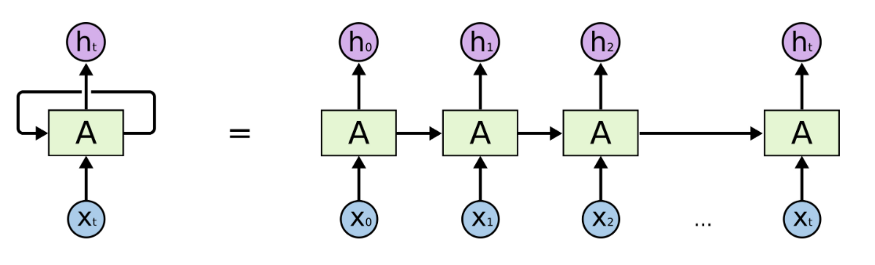

# LSTM을 이용하여 텍스트 분류 문제 해결하기

RNN의 vanilla 버전은 순서의 초기 부분에서 발생한 상황을 기억하기 어렵다는 문제가 있다. (**장기 의존성 문제; long-term dependency problem**)

<br>
LSTM과 RNN의 여러가지 변종은 LSTM 내부에 여러가지 신경망을 추가함으로써 이 문제를 해결할 수 있는데, 얼마나 많이, 어떤 데이터를 기억해야 하는지는 추후에 결정하게 된다.


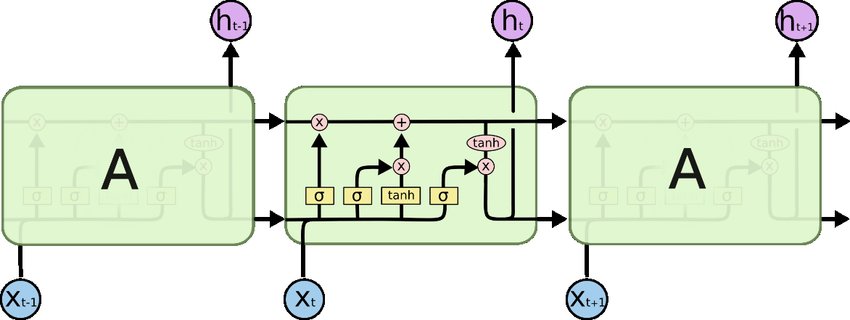

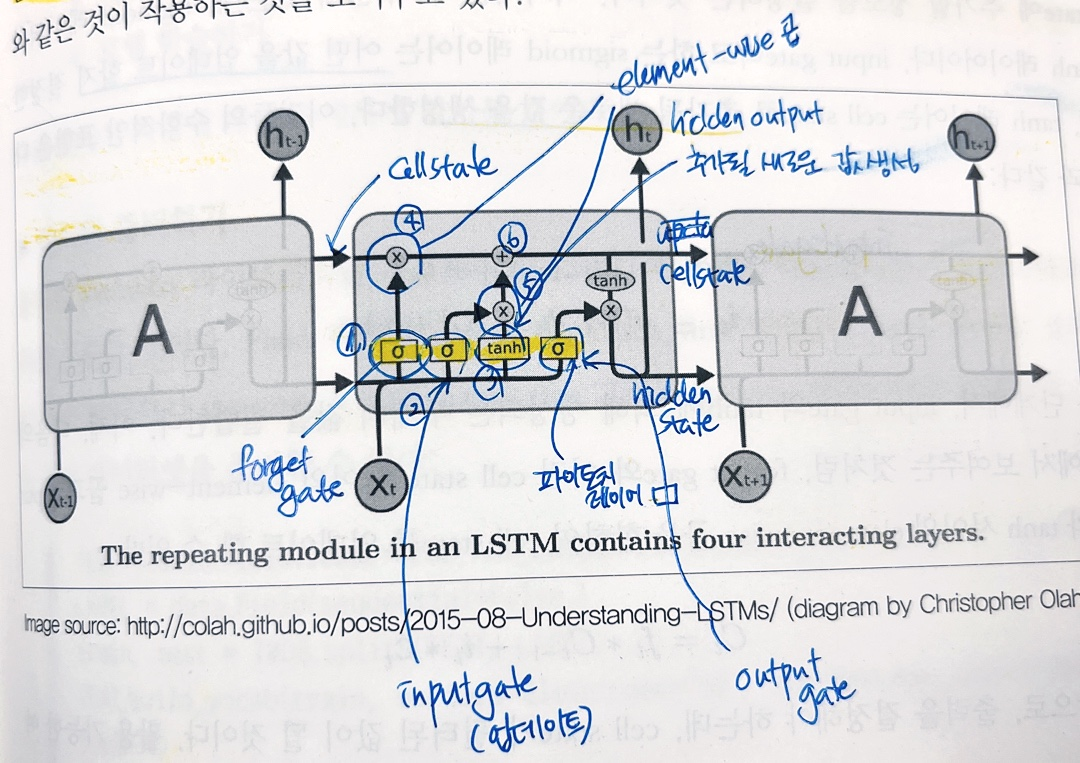

The process of one time step can be divided into four stages:
1. Deciding what information we’re going to keep (throw away) from the cell state. (forget gate)
2. Deciding what new information we’re going to restore in the cell state. (input gate)
3. Updating cell state
4. Deciding what should be outputs. (output gate)

https://medium.com/guan-hong/basic-concepts-of-rnns-b7303e09f7b4


# Sentiment Analysis
1. 데이터 준비하기
2. 배치 생성하기
3. 네트워크 생성하기
4. 모델 학습하기

## 1. 데이터 준비하기<1>

In [5]:
from torchtext.legacy import data
#Field: 토큰화하는 방법을 정의
text = data.Field(lower=True, fix_length = 200,batch_first=False)#실제 텍스트 (모든 텍스트를 소문자(lower)로, 최대길이는 200으로 자름)
label = data.Field(sequential = False,)#레이블 데이터
from torchtext.legacy import datasets
train, test = datasets.IMDB.splits(text,label)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:03<00:00, 26.3MB/s]


In [6]:
TEXT,LABEL = text,label
TEXT.build_vocab(train, vectors = GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=300), max_size= 10000, min_freq = 10)
LABEL.build_vocab(train,)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:57<00:00, 6905.22it/s]


## 2. 배치 생성하기<2>

In [7]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size = 32,
                                                   device =None,# None,#use gpu. device = -1: cpu
                                                   shuffle = True)
train_iter.repeat = False
test_iter.repeat = False

In [8]:
sample_batch = next(iter(train_iter))

In [9]:
sample_batch


[torchtext.legacy.data.batch.Batch of size 32 from IMDB]
	[.text]:[torch.LongTensor of size 200x32]
	[.label]:[torch.LongTensor of size 32]

In [10]:
sample_batch.text

tensor([[  46,    0,   77,  ...,  843,  395,  220],
        [  25,    9,    5,  ...,   33,    5, 9302],
        [  26, 2717,    2,  ..., 8540,   57,   31],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])

In [11]:
len(sample_batch.text)

200

In [12]:
len(sample_batch.text[0])

32

## 3. 네트워크 생성하기<3>

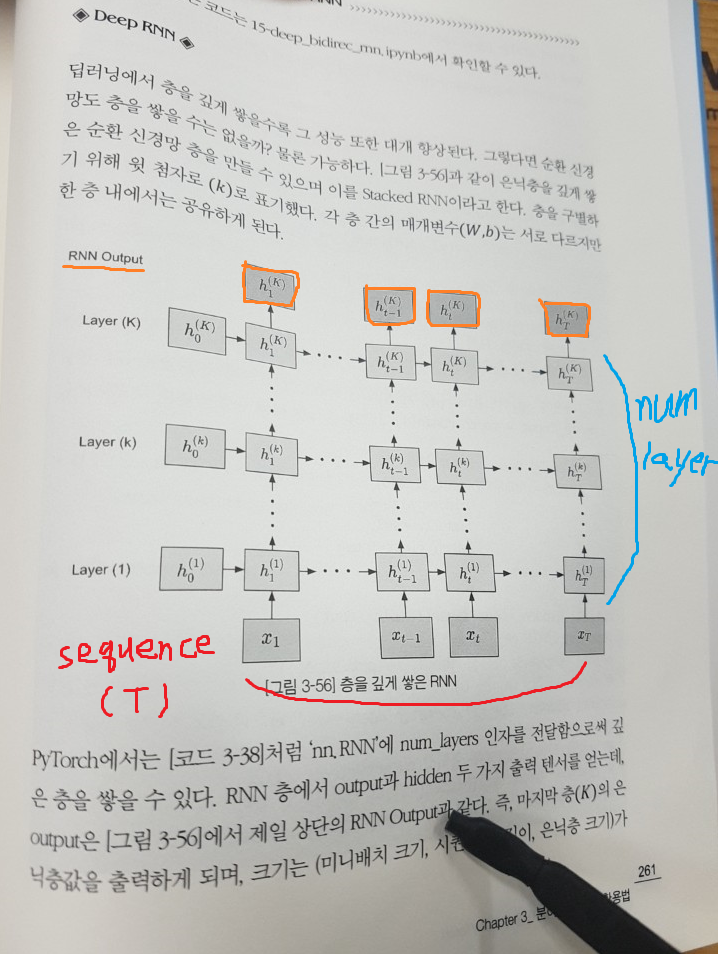


출처: https://coding-yoon.tistory.com/55

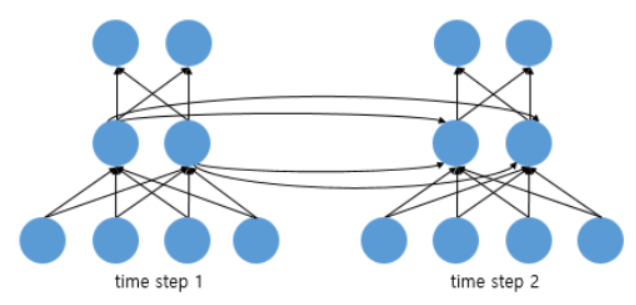

input_size: 4, hidden_size:2, output_size:2, n_layer:1

#### nn.LSTM
- **hidden_size**: The number of features in the hidden state h
- **num_layers**: Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

In [13]:
len(text.vocab.stoi)

10591

In [14]:
class IMDBRnn(nn.Module):
  def __init__(self, vocab, hidden_size, n_cat, bs = 1, nl = 2):
    #vocab: 어휘 수, n_cat: label 수(unknown, pos, neg), bs: batch size nl: num_layer
    #n_vocab = 200
    super(IMDBRnn, self).__init__()
    self.hidden_size = hidden_size
    self.bs = bs#batch size
    self.nl = nl
    self.e = nn.Embedding(vocab, hidden_size)#1xinput_dim[-1]xhidden_size
    #print("hidden_size of LSTM:",hidden_size)
    self.rnn = nn.LSTM(hidden_size, hidden_size, nl)#LSTM
    self.fc2 = nn.Linear(hidden_size, n_cat)#선형 레이어
    self.softmax = nn.LogSoftmax(dim = -1)

  def forward(self, inp):#inp:input
    #print(inp.size())
    #original_inp = inp
    #inp = torch.reshape(inp,(len(inp[0]),len(inp)))
    bs = inp.size()[1]
    #print("bs",bs)
    if bs!=self.bs:
      self.bs = bs
    #print("e_out")
    #print(inp.size())
    e_out = self.e(inp)
    #e_out = torch.transpose(e_out, 0, 1)
    #print(e_out.size())
    #print("h0")
    h0 = c0 = Variable(e_out.data.new(*(self.nl, self.bs, self.hidden_size)).zero_())
    #print("rnn")
    #print("h0 size:",h0.size())
    #print("c0 size:",c0.size())
    rnn_o, _ = self.rnn(e_out, (h0,c0))
    #print("last")
    rnn_o = rnn_o[-1]#마지막 순서의 출력만 취함
    #print(len(rnn_o))
    #print(len(rnn_o[0]))
    #print("fc0")
    #print("rnn_o.size():",rnn_o.size())
    #print("hidden_size of rnn_o:",self.hidden_size)
    rnn_o = rnn_o.reshape(-1, self.hidden_size)
    fc0 = self.fc2(rnn_o)
    #print("fc")
    #print("fc0.size()",fc0.size())
    #fc0 =  torch.transpose(fc0, 0, 1)
    fc = F.dropout(fc0, p = 0.8)#과적합 방지
    #print("result")
    #print(len(fc))
    result = self.softmax(fc)
    return result

In [15]:
len(train_iter)

782

In [16]:
len(test_iter)

782

## 4. 모델 학습하기<4>

In [ ]:
def fit(optimizer, epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == "training":
    model.train()
  if phase == "validation":
    model.eval()

  volatile = True
  running_loss = 0.0
  running_correct = 0

  for batch_idx, batch in enumerate(data_loader):
    #print("batch: {}/128".format(batch_idx+1))
    text, target = batch.text, batch.label
    #print("len",len(batch.text))
    #text, target = text.cuda(), target.cuda()
    
    try:
      text, target = text.cuda(), target.cuda()
    except:#no cuda
      #print("cuda not available")
      pass
    
    if phase == "training":
      optimizer.zero_grad()
    #criterion = nn.CrossEntropyLoss()
    print("len(text):",len(text))#: 32
    output = model(text)
    loss =  F.cross_entropy(output, target)#F.nll_loss(output, target)
    running_loss += F.cross_entropy(output, target, size_average=False).data#[0]
    predictions = output.data.max(dim = 1, keepdim = True)[1]
    running_correct += predictions.eq(target.data.view_as(predictions)).cpu().sum()

    if phase == "training":
      loss.backward()
      optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100.*running_correct/len(data_loader.dataset)
    if batch_idx %100 == 0 or batch_idx == len(data_loader)-1:
      print(f"batch_idx: {batch_idx}/781 | {phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}".format(loss, accuracy))
  return loss, accuracy

In [ ]:
n_vocab = len(text.vocab.stoi)
n_hidden = 200#마지막만 출력할 것이기 때문에 적어도 상관 없을듯?

In [ ]:
model = IMDBRnn(n_vocab, n_hidden, 3, bs = 32)

In [ ]:
model.cuda()

IMDBRnn(
  (e): Embedding(10002, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (fc2): Linear(in_features=200, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [ ]:
train_losses , train_accuracy = [],[] 
validation_losses , validation_accuracy = [],[]

train_iter.repeat = False#배치 생성 멈춤
test_iter.repeat = False#배치 생성 멈춤
for epoch in range(1,10):
    print("================epoch{}/9===============".format(epoch))
    epoch_loss, epoch_accuracy = fit(optimizer, epoch,model,train_iter,phase='training')
    validation_epoch_loss, validation_epoch_accuracy = fit(optimizer, epoch,model,test_iter,phase='validation')
    train_losses.append(epoch_loss) 
    train_accuracy.append(epoch_accuracy) 
    validation_losses.append(validation_epoch_loss) 
    validation_accuracy.append(validation_epoch_accuracy)

================epoch1/9===============


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch_idx: 0/781 | training loss is 0.0014 and training accuracy is 4/25000     0.016
batch_idx: 100/781 | training loss is  0.13 and training accuracy is 751/25000     3.004
batch_idx: 200/781 | training loss is  0.26 and training accuracy is 1548/25000     6.192
batch_idx: 300/781 | training loss is  0.39 and training accuracy is 2318/25000     9.272
batch_idx: 400/781 | training loss is  0.52 and training accuracy is 3082/25000     12.33
batch_idx: 500/781 | training loss is  0.65 and training accuracy is 3843/25000     15.37
batch_idx: 600/781 | training loss is  0.77 and training accuracy is 4645/25000     18.58
batch_idx: 700/781 | training loss is   0.9 and training accuracy is 5417/25000     21.67
batch_idx: 781/781 | training loss is   1.0 and training accuracy is 6068/25000     24.27
batch_idx: 0/781 | validation loss is 0.0013 and validation accuracy is 4/25000     0.016
batch_idx: 100/781 | validation loss is  0.13 and validation accuracy is 782/25000     3.128
batch_idx: 2

In [ ]:
validation_accuracy

[]

model has so low an accuracy<br>
try with n_ll loss

In [ ]:
def fit(optimizer, epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == "training":
    model.train()
  if phase == "validation":
    model.eval()

  volatile = True
  running_loss = 0.0
  running_correct = 0

  for batch_idx, batch in enumerate(data_loader):
    #print("batch: {}/128".format(batch_idx+1))
    text, target = batch.text, batch.label
    #print("len",len(batch.text))
    #text, target = text.cuda(), target.cuda()
    
    try:
      text, target = text.cuda(), target.cuda()
    except:#no cuda
      #print("cuda not available")
      pass
    
    if phase == "training":
      optimizer.zero_grad()
    #criterion = nn.CrossEntropyLoss()
    #print("len(batch.text):",len(batch.text))#: 32
    output = model(text)
    loss =  F.nll_loss(output, target)
    running_loss += F.nll_loss(output, target, size_average=False).data#[0]
    predictions = output.data.max(dim = 1, keepdim = True)[1]
    running_correct += predictions.eq(target.data.view_as(predictions)).cpu().sum()

    if phase == "training":
      loss.backward()
      optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100.*running_correct/len(data_loader.dataset)
    if batch_idx %100 == 0 or batch_idx == len(data_loader)-1:
      print(f"batch_idx: {batch_idx}/781 | {phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}".format(loss, accuracy))
  return loss, accuracy

In [ ]:
train_losses , train_accuracy = [],[] 
validation_losses , validation_accuracy = [],[]
no_update = 0
prev = 0
train_iter.repeat = False#배치 생성 멈춤
test_iter.repeat = False#배치 생성 멈춤
for epoch in range(1,3):
    print("================epoch{}/2===============".format(epoch))
    epoch_loss, epoch_accuracy = fit(optimizer, epoch,model,train_iter,phase='training')
    validation_epoch_loss, validation_epoch_accuracy = fit(optimizer, epoch,model,test_iter,phase='validation')
    #print(validation_epoch_accuracy)
    if validation_epoch_accuracy < prev:
      no_update += 1
    prev = validation_epoch_accuracy
    if no_update >2:
      print("model has shown no improvement for 3 times, halting training")
      break
    train_losses.append(epoch_loss) 
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss) 
    validation_accuracy.append(validation_epoch_accuracy)

### design my own LSTM due to poor performance of previous models in book

In [17]:
from torchtext.legacy import data
#Field: 토큰화하는 방법을 정의
text = data.Field(lower=True, fix_length = 200,batch_first=True)#실제 텍스트 (모든 텍스트를 소문자(lower)로, 최대길이는 200으로 자름)
label = data.Field(sequential = False,)#레이블 데이터
from torchtext.legacy import datasets
train, test = datasets.IMDB.splits(text,label)

In [18]:
TEXT,LABEL = text,label
TEXT.build_vocab(train, vectors = GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=300), max_size= 10000, min_freq = 10)
LABEL.build_vocab(train,)

In [19]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size = 32,
                                                   device =None,# None,#use gpu. device = -1: cpu
                                                   shuffle = True)
train_iter.repeat = False
test_iter.repeat = False

In [85]:
class IMDBLSTM(nn.Module):
  def __init__(self, vocab, embedding_dim, hidden_size, n_cat, bs, nl):
    #vocab: 어휘 수, n_cat: label 수(unknown, pos, neg), bs: batch size nl: num_layer
    super(IMDBLSTM, self).__init__()
    print(f"vocab_size:{vocab}, embedding_dim:{embedding_dim}, hidden_size:{hidden_size},n_cat:{n_cat}, batch size:{bs}, nl:{nl}")
    self.hidden_size = hidden_size
    self.bs = bs#batch size
    self.nl = nl
    self.embedding = nn.Embedding(vocab, embedding_dim, padding_idx = 0)#1xinput_dim[-1]xhidden_size
    #print("hidden_size of LSTM:",hidden_size)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, nl, batch_first = True)#LSTM
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_size, n_cat)#선형 레이어

  def forward(self, inp,hidden):#inp:input
    #print("inp:",inp.size())
    bs = inp.size()[0]
    if bs!=self.bs:
      self.bs = bs
    embs = self.embedding(inp)
    h0 = c0 = Variable(embs.data.new(*(self.nl, self.bs, self.hidden_size)).zero_())
    hidden = (h0,c0)
    rnn_o, hidden = self.lstm(embs, hidden)
    
    out = self.dropout(rnn_o)
    out = self.fc(out)
    out = out[:,-1]#마지막 순서의 출력만 취함
    return out,hidden

  def init_hidden(self):
    return (torch.zeros(self.nl, self.bs, self.hidden_size), torch.zeros(self.nl, self.bs, self.hidden_size))

In [86]:
n_vocab = len(text.vocab.stoi)
n_embed = 100

In [87]:
model = IMDBLSTM(n_vocab, n_embed, hidden_size=200,n_cat=3, bs=32, nl=2)

vocab_size:188151, embedding_dim:100, hidden_size:200,n_cat:3, batch size:32, nl:2


In [88]:
model.cuda()

IMDBLSTM(
  (embedding): Embedding(188151, 100, padding_idx=0)
  (lstm): LSTM(100, 200, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=3, bias=True)
)

In [89]:
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [90]:
def fit(h0,c0,optimizer, epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == "training":
    model.train()
  if phase == "validation":
    model.eval()

  volatile = True
  running_loss = 0.0
  running_correct = 0

  for batch_idx, batch in enumerate(data_loader):
    #print("batch: {}/128".format(batch_idx+1))
    text, target = batch.text, batch.label
    #print("len",len(batch.text))
    #text, target = text.cuda(), target.cuda()
    try:
      text, target = text.cuda(), target.cuda()
    except:#no cuda
      print("cuda not available")
      pass
    
    if phase == "training":
      optimizer.zero_grad()
      
    output,hidden = model(text,(h0,c0))
    #print("output size:",output.size())
    #print("target:",target)
    loss =  F.cross_entropy(output, target)
    running_loss += F.cross_entropy(output, target, size_average=False).data#[0]
    predictions = output.data.max(dim = 1, keepdim = True)[1]
    #print("predictions:",predictions)
    running_correct += predictions.eq(target.data.view_as(predictions)).cpu().sum()

    if phase == "training":
      loss.backward()
      optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100.*running_correct/len(data_loader.dataset)
    if batch_idx %100 == 0 or batch_idx == len(data_loader)-1:
      print(f"batch_idx: {batch_idx}/781 | {phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}".format(loss, accuracy))
  return loss, accuracy

In [92]:
train_losses , train_accuracy = [],[] 
validation_losses , validation_accuracy = [],[]
no_update = 0
prev = 0
train_iter.repeat = False#배치 생성 멈춤
test_iter.repeat = False#배치 생성 멈춤
for epoch in range(1,4):
    print("================epoch{}/3===============".format(epoch))
    h0, c0 =  model.init_hidden()
    h0 = h0.cuda()
    c0 = c0.cuda()
    epoch_loss, epoch_accuracy = fit(h0,c0,optimizer, epoch,model,train_iter,phase='training')
    validation_epoch_loss, validation_epoch_accuracy = fit(h0,c0,optimizer, epoch,model,test_iter,phase='validation')
    #print(validation_epoch_accuracy)
    if validation_epoch_accuracy < prev:
      no_update += 1
    prev = validation_epoch_accuracy
    if no_update >2:
      print("model has shown no improvement for 3 times, halting training")
      break
    train_losses.append(epoch_loss) 
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss) 
    validation_accuracy.append(validation_epoch_accuracy)

================epoch1/3===============
batch_idx: 0/781 | training loss is 0.00089 and training accuracy is 18/25000     0.072


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch_idx: 100/781 | training loss is  0.09 and training accuracy is 1643/25000     6.572
batch_idx: 200/781 | training loss is  0.18 and training accuracy is 3261/25000     13.04
batch_idx: 300/781 | training loss is  0.27 and training accuracy is 4859/25000     19.44
batch_idx: 400/781 | training loss is  0.36 and training accuracy is 6456/25000     25.82
batch_idx: 500/781 | training loss is  0.45 and training accuracy is 8059/25000     32.24
batch_idx: 600/781 | training loss is  0.54 and training accuracy is 9667/25000     38.67
batch_idx: 700/781 | training loss is  0.62 and training accuracy is 11348/25000     45.39
batch_idx: 781/781 | training loss is   0.7 and training accuracy is 12626/25000      50.5
batch_idx: 0/781 | validation loss is 0.00087 and validation accuracy is 20/25000      0.08
batch_idx: 100/781 | validation loss is 0.089 and validation accuracy is 1761/25000     7.044
batch_idx: 200/781 | validation loss is  0.18 and validation accuracy is 3379/25000     13.5

# 순차 데이터에 대한 합성곱 네트워크


## 데이터 준비+배치 생성
위 코드에서 batch_first = True로 변경해야 한다

In [93]:
from torchtext.legacy import data
#Field: 토큰화하는 방법을 정의
text = data.Field(lower=True, fix_length = 200,batch_first=True)#실제 텍스트 (모든 텍스트를 소문자(lower)로, 최대길이는 20으로 자름)
label = data.Field(sequential = False,)#레이블 데이터
from torchtext.legacy import datasets
train, test = datasets.IMDB.splits(text,label)

TEXT,LABEL = text,label
TEXT.build_vocab(train, vectors = GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=300), max_size= 10000, min_freq = 10)
LABEL.build_vocab(train,)
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size = 32,
                                                   device =-1,# None,#use gpu. device = -1: cpu
                                                   shuffle = True)
train_iter.repeat = False
test_iter.repeat = False

## 네트워크 생성

In [95]:
class IMDBCnn(nn.Module):
  def __init__(self, vocab, hidden_size, n_cat, bs =1, kernel_size = 3, max_len = 200):
    super().__init__()
    self.hidden_size = hidden_size
    self.bs = bs#batch size
    self.e = nn.Embedding(n_vocab, hidden_size)
    self.cnn = nn.Conv1d(max_len, hidden_size, kernel_size)#max_len: 순서 길이(sequence length)
    self.avg = nn.AdaptiveAvgPool1d(10)#10의 크기를 반환
    self.fc = nn.Linear(1000,n_cat)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, inp):
    bs = inp.size()[0]
    if bs != self.bs:
      self.bs = bs
    e_out = self.e(inp)
    cnn_o = self.cnn(e_out)
    cnn_avg = self.avg(cnn_o)
    cnn_avg = cnn_avg.view(self.bs,-1)
    fc = F.dropout(self.fc(cnn_avg),p=0.5)
    return self.softmax(fc)

In [105]:
model = IMDBCnn(n_vocab, 100, 3, bs = 32)
model.cuda()

IMDBCnn(
  (e): Embedding(188151, 100)
  (cnn): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
  (avg): AdaptiveAvgPool1d(output_size=10)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [106]:
optimizer = optim.Adam(model.parameters(),lr=0.01)

#### 훈련

In [107]:
def fit(optimizer, epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == "training":
    model.train()
  if phase == "validation":
    model.eval()

  volatile = True
  running_loss = 0.0
  running_correct = 0

  for batch_idx, batch in enumerate(data_loader):
    #print("batch: {}/128".format(batch_idx+1))
    text, target = batch.text, batch.label
    #print("len",len(batch.text))
    #text, target = text.cuda(), target.cuda()
    
    try:
      text, target = text.cuda(), target.cuda()
    except:#no cuda
      #print("cuda not available")
      pass
    
    if phase == "training":
      optimizer.zero_grad()
    #criterion = nn.CrossEntropyLoss()
    #print("len(batch.text):",len(batch.text))#: 32
    output = model(text)
    loss =  F.nll_loss(output, target)
    running_loss += F.nll_loss(output, target, size_average=False).data#[0]
    predictions = output.data.max(dim = 1, keepdim = True)[1]
    running_correct += predictions.eq(target.data.view_as(predictions)).cpu().sum()

    if phase == "training":
      loss.backward()
      optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100.*running_correct/len(data_loader.dataset)
    if batch_idx %100 == 0 or batch_idx == len(data_loader)-1:
      print(f"batch_idx: {batch_idx}/781 | {phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}".format(loss, accuracy))
  return loss, accuracy

In [108]:
train_losses , train_accuracy = [],[] 
validation_losses , validation_accuracy = [],[]
no_update = 0
prev = 0
train_iter.repeat = False#배치 생성 멈춤
test_iter.repeat = False#배치 생성 멈춤
for epoch in range(1,6):
    print("================epoch{}/5===============".format(epoch))
    epoch_loss, epoch_accuracy = fit(optimizer, epoch, model,train_iter,phase='training')
    validation_epoch_loss, validation_epoch_accuracy = fit(optimizer, epoch,model,test_iter,phase='validation')
    #print(validation_epoch_accuracy)
    if validation_epoch_accuracy < prev:
      no_update += 1
    prev = validation_epoch_accuracy
    if no_update >2:
      print("model has shown no improvement for 3 times, halting training")
      break
    train_losses.append(epoch_loss) 
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss) 
    validation_accuracy.append(validation_epoch_accuracy)

================epoch1/5===============
batch_idx: 0/781 | training loss is 0.0015 and training accuracy is 3/25000     0.012


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch_idx: 100/781 | training loss is  0.21 and training accuracy is 1186/25000     4.744
batch_idx: 200/781 | training loss is  0.48 and training accuracy is 2419/25000     9.676
batch_idx: 300/781 | training loss is  0.75 and training accuracy is 3738/25000     14.95
batch_idx: 400/781 | training loss is   1.0 and training accuracy is 5122/25000     20.49
batch_idx: 500/781 | training loss is   1.3 and training accuracy is 6642/25000     26.57
batch_idx: 600/781 | training loss is   1.6 and training accuracy is 8091/25000     32.36
batch_idx: 700/781 | training loss is   1.9 and training accuracy is 9645/25000     38.58
batch_idx: 781/781 | training loss is   2.1 and training accuracy is 10927/25000     43.71
batch_idx: 0/781 | validation loss is 0.0032 and validation accuracy is 10/25000      0.04
batch_idx: 100/781 | validation loss is  0.23 and validation accuracy is 1612/25000     6.448
batch_idx: 200/781 | validation loss is  0.51 and validation accuracy is 3219/25000     12.88


개선 가능 options:
- 사전 학습된 가중치 사용 ✔(6B)
- 또 다른 합성곱 레이어 추가
- 합성곱 레이어들 사이에 MaxPool1d 적용

#### 개선: 또 다른 합성곱 레이어 추가 + MaxPool1d 적용

In [110]:
class IMDBCnn(nn.Module):
  def __init__(self, vocab, hidden_size, n_cat, bs =1, kernel_size = 3, max_len = 200):
    super().__init__()
    self.hidden_size = hidden_size
    self.bs = bs#batch size
    self.e = nn.Embedding(n_vocab, hidden_size)
    self.cnn = nn.Conv1d(max_len, 256, kernel_size)#max_len: 순서 길이(sequence length)
    self.cnn2 = nn.Conv1d(256, hidden_size, kernel_size)#합성곱 레이어 추가
    self.pool = nn.MaxPool1d(kernel_size=3, stride=1)#MaxPool1d적용
    self.avg = nn.AdaptiveAvgPool1d(10)#10의 크기를 반환
    self.fc = nn.Linear(1000,n_cat)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, inp):
    bs = inp.size()[0]
    if bs != self.bs:
      self.bs = bs
    e_out = self.e(inp)
    cnn_o = self.cnn(e_out)
    pool_o = self.pool(cnn_o)
    cnn_o = self.cnn2(pool_o)
    cnn_avg = self.avg(cnn_o)
    cnn_avg = cnn_avg.view(self.bs,-1)
    fc = F.dropout(self.fc(cnn_avg),p=0.5)
    return self.softmax(fc)

In [111]:
model = IMDBCnn(n_vocab, 100, 3, bs = 32)
model.cuda()

IMDBCnn(
  (e): Embedding(188151, 100)
  (cnn): Conv1d(200, 256, kernel_size=(3,), stride=(1,))
  (cnn2): Conv1d(256, 100, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (avg): AdaptiveAvgPool1d(output_size=10)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [112]:
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [113]:
train_losses , train_accuracy = [],[] 
validation_losses , validation_accuracy = [],[]
no_update = 0
prev = 0
train_iter.repeat = False#배치 생성 멈춤
test_iter.repeat = False#배치 생성 멈춤
for epoch in range(1,6):
    print("================epoch{}/5===============".format(epoch))
    epoch_loss, epoch_accuracy = fit(optimizer, epoch, model,train_iter,phase='training')
    validation_epoch_loss, validation_epoch_accuracy = fit(optimizer, epoch,model,test_iter,phase='validation')
    #print(validation_epoch_accuracy)
    if validation_epoch_accuracy < prev:
      no_update += 1
    prev = validation_epoch_accuracy
    if no_update >2:
      print("model has shown no improvement for 3 times, halting training")
      break
    train_losses.append(epoch_loss) 
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss) 
    validation_accuracy.append(validation_epoch_accuracy)

================epoch1/5===============
batch_idx: 0/781 | training loss is 0.0014 and training accuracy is 14/25000     0.056


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch_idx: 100/781 | training loss is   0.6 and training accuracy is 1177/25000     4.708
batch_idx: 200/781 | training loss is  0.78 and training accuracy is 2384/25000     9.536
batch_idx: 300/781 | training loss is   3.6 and training accuracy is 3568/25000     14.27
batch_idx: 400/781 | training loss is   5.4 and training accuracy is 4860/25000     19.44
batch_idx: 500/781 | training loss is   6.3 and training accuracy is 6348/25000     25.39
batch_idx: 600/781 | training loss is   7.0 and training accuracy is 7846/25000     31.38
batch_idx: 700/781 | training loss is   8.1 and training accuracy is 9360/25000     37.44
batch_idx: 781/781 | training loss is   9.5 and training accuracy is 10624/25000      42.5
batch_idx: 0/781 | validation loss is 0.058 and validation accuracy is 12/25000     0.048
batch_idx: 100/781 | validation loss is   2.3 and validation accuracy is 1487/25000     5.948
batch_idx: 200/781 | validation loss is   4.3 and validation accuracy is 3114/25000     12.46
b

으음 아주 조금 성능이 좋아진듯

# GPT-2 사용해보기

In [115]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 131 kB 9.9 MB/s 
     |████████████████████████████████| 8.5 MB 515 kB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 138 kB 46.1 MB/s 
     |████████████████████████████████| 127 kB 49.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
from torch.nn import functional as F
from pytorch_pretrained_bert import *

In [3]:
import pytorch_pretrained_bert
tokenizer = pytorch_pretrained_bert.GPT2Tokenizer.from_pretrained('gpt2')
gtp2model = pytorch_pretrained_bert.GPT2LMHeadModel.from_pretrained('gpt2')

100%|██████████| 665/665 [00:00<00:00, 366712.09B/s]


In [4]:
prior_part = "We love unicorns because they"
input_text = tokenizer.encode(prior_part)
input, past = torch.tensor([input_text]),None

for _ in range(25):
  logits, past = gtp2model(input, past = past)
  input = torch.multinomial(F.softmax(logits[:,-1]),1)
  input_text.append(input.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [6]:
tokenizer.decode(input_text)

'We love unicorns because they are completely winning the day and causing people to be thoughtful and kind and thoughtful. We love and celebrate their cultures and traditions,'